In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/data/hanoi_quality.csv'
ratio = 0.7
title = "GRU Model PM2.5 Forecast for Next 90 Days: Ha Noi - 7:3"

In [3]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Fill remaining NaN values
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)

    return forecast_smoothed_filled

In [4]:
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
df.drop(columns=['date'], inplace=True)
df = smoothed(df)
df1=df.reset_index()['pm25']
df1.shape

(1920,)

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(ratio  * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
21/21 [==============================] - 3s 45ms/step - loss: 0.0232 - val_loss: 0.0112
Epoch 2/50
21/21 [==============================] - 0s 20ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 3/50
21/21 [==============================] - 0s 20ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 4/50
21/21 [==============================] - 0s 19ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 5/50
21/21 [==============================] - 0s 21ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 6/50
21/21 [==============================] - 0s 21ms/step - loss: 0.0049 - val_loss: 0.0061
Epoch 7/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 8/50
21/21 [==============================] - 1s 34ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 9/50
21/21 [==============================] - 1s 31ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 10/50
21/21 [==============================] - 1s 34ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 11/

In [12]:
X_test.shape

(545, 30, 1)

In [13]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))

18/18 [==============================] - 0s 2ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 7.05905034890515
Testing MAPE: 7.357419138497802
Testing MAE: 6.401972862084707


In [16]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 516)

In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 0.31286895 0.32349469 0.35655254 0.38488784 0.38016529 0.40731995
 0.30932704 0.25855962 0.29397875 0.29752066 0.29515939 0.43211334
 0.56552538 0.63754427 0.5690673  0.71192444 0.72609209 0.72609209
 0.69421488 0.85123967 0.81936246 0.83353011 0.8772137  0.9149941
 0.82998819 0.76269185 0.69539551 0.55608028 0.48524203 0.53719008
 0.55608028 0.58677686 0.67178276 0.63282172 0.60802834 0.5879575
 0.52420307 0.46044864 0.45572609 0.43801653 0.37072019 0.41086187
 0.37544274 0.35419126 0.38606848 0.44864227 0.47343566 0.59149941
 0.60566706 0.57733176 0.48996458 0.42266824 0.45218418 0.5974026
 0.64698937 0.78394333 0.80873672 0.67650531 0.59386068 0.63400236
 0.59386068 0.59031877 0.61393152 0.56670602 0.48524203 0.42030697
 0.34474616 0.33530106 0.37544274 0.40495868 0.46280992 0.55844156
 0.52774498 0.51829988 0.41794569 0.38134593 0.37072019 0.43801653
 0.39197166 0.47107438 0.52656434 0.53719008 0.50885478 0.56552538
 0.64817001 0.

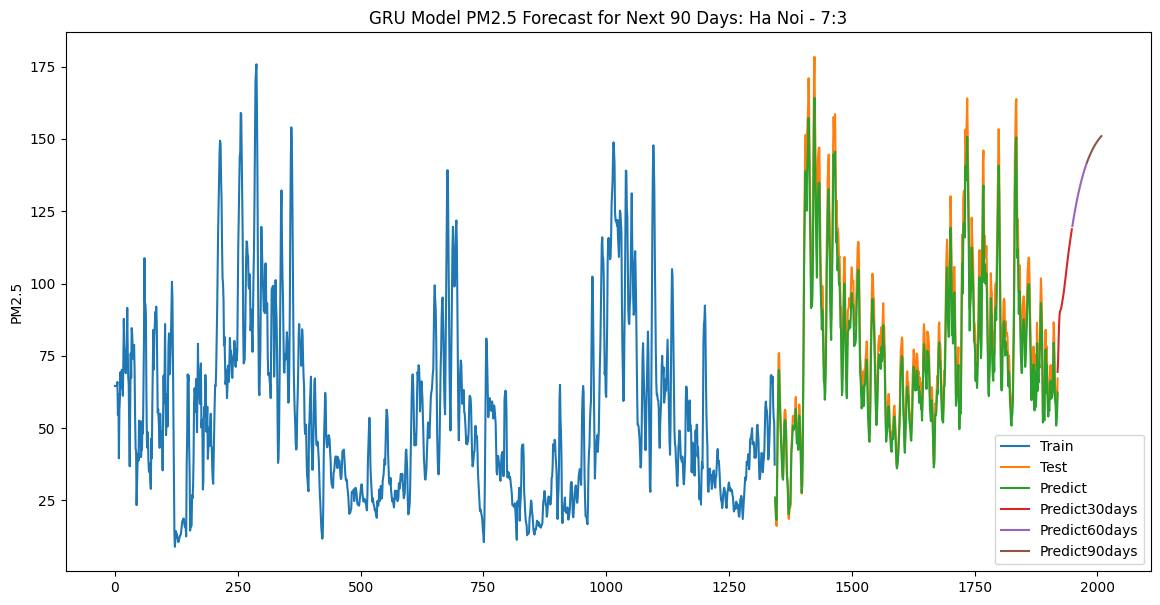

In [18]:
# 14.Vẽ hình

plt.figure(figsize=(14, 7))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))

plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title(title)
plt.ylabel('PM2.5')
plt.show()

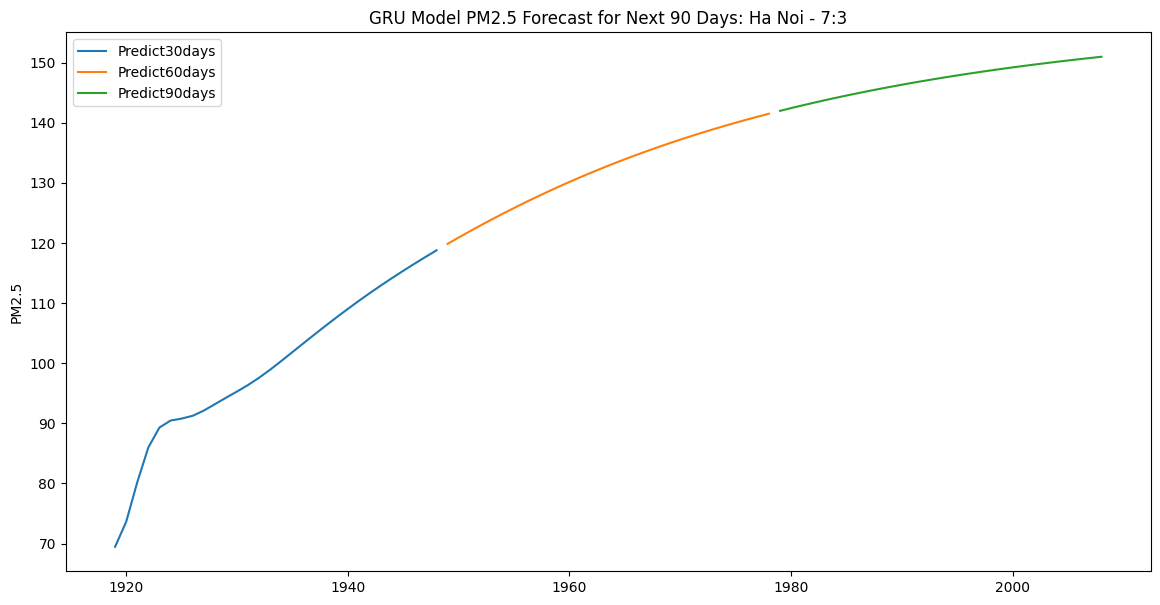

In [19]:
plt.figure(figsize=(14, 7))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title(title)
plt.ylabel('PM2.5')
plt.show()